In [1]:
import torch
from torch import nn
from d2l import torch as d2l
from get_data_loader import load_data_imdb

batch_size = 64
train_iter, test_iter, vocab = load_data_imdb(batch_size)

/home/tian/anaconda3/envs/d2l/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
# Given an input tensor X and a kernel tensor K, it returns the output tensor Y.

def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i + w] * K).sum()
    return Y

In [4]:
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2])
corr1d(X, K)
# [0*1 + 1*2, 1*1 +2*2, 2*1 + 3*2, 3*1 + 4*2, 4*1 + 5*2, 5*1 + 6*2]

tensor([ 2.,  5.,  8., 11., 14., 17.])

In [5]:
def corr1d_multi_in(X, K):
    # First, iterate through the 0th dimension (channel dimension) of `X` and
    # `K`. Then, add them together
    return sum(corr1d(x, k) for x, k in zip(X, K))

X = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
              [1, 2, 3, 4, 5, 6, 7],
              [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

For a single text sequence with tokens represented by 

d-dimensional vectors, the width, height, and number of channels of the input tensor are n, 1,and d, respectively.

 The textCNN model transforms the input into the output as follows:

1. Define multiple one-dimensional convolution kernels and perform convolution operations separately on the inputs. Convolution kernels with different widths may capture local features among different numbers of adjacent tokens.

2. Perform max-over-time pooling on all the output channels, and then concatenate all the scalar pooling outputs as a vector.

3. Transform the concatenated vector into the output categories using the fully connected layer. Dropout can be used for reducing overfitting.

model

In [7]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels, **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer not to be trained
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # The max-over-time pooling layer has no parameters, so this instance
        # can be shared
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))
    def forward(self, inputs):
        # Concatenate two embedding layer outputs with shape (batch size, no.
        # of tokens, token vector dimension) along vectors
        embeddings = torch.cat((self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # Per the input format of one-dimensional convolutional layers,
        # rearrange the tensor so that the second dimension stores channels
        embeddings = embeddings.permute(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor of shape (batch size, no. of channels, 1) is
        # obtained. Remove the last dimension and concatenate along channels
        encoding = torch.cat([torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

Initialize model para

In [39]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(module):
    if type(module) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)

net.apply(init_weights)

TextCNN(
  (embedding): Embedding(49346, 100)
  (constant_embedding): Embedding(49346, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=300, out_features=2, bias=True)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (relu): ReLU()
  (convs): ModuleList(
    (0): Conv1d(200, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(200, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(200, 100, kernel_size=(5,), stride=(1,))
  )
)

Pre-trained WV

In [40]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

figure out the dim

In [37]:
for features, labels in train_iter:
    x = net.embedding(features)
    y = net.constant_embedding(features)
    x_y = torch.cat((x, y), dim=2)
    p_x_y = x_y.permute(0, 2, 1)    # batch_size, embedding_size, hidden_size*2
    c = torch.zeros(3, 64, 100)
    for i, conv in enumerate(net.convs):  # #layers = #channels = #kernels
        cc = conv(p_x_y) # 498 = 500 - 3 + 1
        pool_c = net.pool(cc)
        relu_pool_c = net.relu(pool_c)
        f_r_pool_c = torch.squeeze(relu_pool_c, dim=-1)
        c[i] = f_r_pool_c
        print(f'for {i}: {c.shape}\npool_c: {pool_c.shape}\nrelu_pool_c: {relu_pool_c.shape}\nf_r_pool_c: {f_r_pool_c.shape}\n')

    c_c = torch.cat((c[0], c[1], c[2]), dim=1)
    print(f'c_c: {c_c.shape}')
    
    # after cat dim=1: out.shape == 6400, 1


    
    print(f'feature: {features.shape}\nx: {x.shape}\ny: {y.shape}\nx_y: {x_y.shape}\np_x_y: {p_x_y.shape}')
    break

for 0: torch.Size([3, 64, 100])
pool_c: torch.Size([64, 100, 1])
relu_pool_c: torch.Size([64, 100, 1])
f_r_pool_c: torch.Size([64, 100])

for 1: torch.Size([3, 64, 100])
pool_c: torch.Size([64, 100, 1])
relu_pool_c: torch.Size([64, 100, 1])
f_r_pool_c: torch.Size([64, 100])

for 2: torch.Size([3, 64, 100])
pool_c: torch.Size([64, 100, 1])
relu_pool_c: torch.Size([64, 100, 1])
f_r_pool_c: torch.Size([64, 100])

c_c: torch.Size([64, 300])
feature: torch.Size([64, 500])
x: torch.Size([64, 500, 100])
y: torch.Size([64, 500, 100])
x_y: torch.Size([64, 500, 200])
p_x_y: torch.Size([64, 200, 500])


training

In [42]:
learninig_rate = 0.001
num_epochs = 5


optimizer = torch.optim.Adam(net.parameters(), lr=learninig_rate)
criterion = nn.CrossEntropyLoss(reduction='sum')
# setp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

loss 0.076, train acc 0.974, test acc 0.876
5984.9 examples/sec on cuda


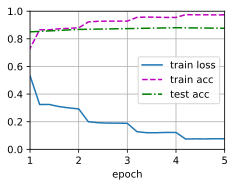

In [43]:
""" I only have one gpu :-( """
device = torch.device('cuda')

timer, num_batches = d2l.Timer(), len(train_iter)
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], legend=['train loss', 'train acc', 'test acc'])

net = net.to(device)

for epoch in range(num_epochs):
    # Sum of training loss, sum of training accuracy, no. of examples,
    # no. of predictions
    metric = d2l.Accumulator(4)

    for i, (features, labels) in enumerate(train_iter):
        timer.start()
        if isinstance(features, list):
            # Required for BERT fine-tuning (to be covered later)
            X = [x.to(device) for x in features]
        else:
            X = features.to(device)
        
        # X = features.to(device)
        y = labels.to(device)

        net.train()
        pred = net(X)

        optimizer.zero_grad()
        l = criterion(pred, y)
        l.backward()
        optimizer.step()
        train_acc_sum = d2l.accuracy(pred, y)
        

        metric.add(l.item(), train_acc_sum, labels.shape[0], labels.numel())
        timer.stop()


        if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
            print(l.item())
            animator.add(epoch + (i + 1) / num_batches,(metric[0] / metric[2], metric[1] / metric[3], None))
            
    # setp_lr_scheduler.step()


    test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))


print(f'loss {metric[0] / metric[2]:.3f}, train acc '
        f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(device)}')

Inference

In [44]:
#@save
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    with torch.no_grad():
        sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
        label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
        return 'positive' if label == 1 else 'negative'

In [50]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [46]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

'negative'